In [21]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
#Load data
Data_clean = pd.read_excel('data_balanced.xlsx')

In [23]:
#Get info
Data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41978 entries, 0 to 41977
Data columns (total 21 columns):
month                  41978 non-null int64
Age                    41978 non-null int64
Amount_netCN           41978 non-null float64
TermOfPaymentDays      41978 non-null int64
GDP by State           41978 non-null int64
Unemployment rate      41978 non-null float64
ZIP                    41978 non-null int64
DefaultStatus          41978 non-null int64
month1                 41978 non-null int64
month2                 41978 non-null int64
month3                 41978 non-null int64
month4                 41978 non-null int64
month5                 41978 non-null int64
month6                 41978 non-null int64
month7                 41978 non-null int64
month8                 41978 non-null int64
month9                 41978 non-null int64
month10                41978 non-null int64
month11                41978 non-null int64
month12                41978 non-null int64
Feq_def

In [24]:
# check null (Print a null value column array)
print(Data_clean.columns[Data_clean.isnull().any()])

Index([], dtype='object')


In [25]:
#Create features and target
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]
#Scale data
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.3, random_state=123)

In [26]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression()

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
#c_space = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['lbfgs']  #, 'liblinear'
param_grid = {'C': c_space, 'solver':solver}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(estimator=clf_logistic, param_grid=param_grid, cv=5 , scoring='roc_auc') 

# Fit it to the data
logreg_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                         'solver': ['lbfgs'

In [27]:
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 163789.3706954068, 'solver': 'lbfgs'}
Best score is 0.8010768768673541


In [28]:
#Create pipeline
pipeline_lg = LogisticRegression(**logreg_cv.best_params_)
#fit data
pipeline_lg.fit(X_train, np.ravel(y_train))

LogisticRegression(C=163789.3706954068, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
#Get the best params
pipeline_lg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=163789.3706954068, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [30]:
# Create predictions of probability for default status using test data
preds = pipeline_lg.predict_proba(X_test)  #preds is proba

# Create dataframes predictions and the true labels
preds_df = pd.DataFrame(preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)

,DefaultStatus,prob_default
0,1,0.408977
1,1,0.692474
2,0,0.104272
3,0,0.182848
4,0,0.592117
...,...,...
12589,1,0.416419
12590,0,0.823959
12591,1,0.701793
12592,1,0.546730


In [31]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default']) #preds_df is proba

# Reassign default status based on the threshold
preds_df['DefaultStatus'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.25 else 0)  

In [32]:
# Print the row counts for each default status
print(preds_df['DefaultStatus'].value_counts())

1    9822
0    2772
Name: DefaultStatus, dtype: int64


In [33]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['DefaultStatus'], target_names=target_names))

precision    recall  f1-score   support

 Non-Default       0.84      0.37      0.52      6207
     Default       0.60      0.93      0.73      6387

    accuracy                           0.65     12594
   macro avg       0.72      0.65      0.62     12594
weighted avg       0.72      0.65      0.63     12594



In [34]:
#Print confusion matrix
print(confusion_matrix(y_test,preds_df['DefaultStatus']))

[[2317 3890]
 [ 455 5932]]


In [35]:
# # Print the accuracy score the model
# print(pipeline_lg.score(X_test, y_test))

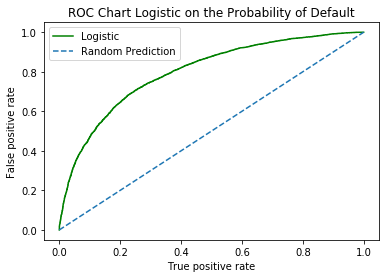

In [36]:
# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]  # #preds is proba

# ROC chart components
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)  #prob_default is prob
plt.plot(fallout, sensitivity, color = 'green', label='%s' % 'Logistic')
plt.title("ROC Chart Logistic on the Probability of Default")
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.xlabel('True positive rate')   #'Fall-out'
plt.ylabel('False positive rate')  #'Sensitivity'
plt.legend()
plt.show()

In [37]:
# # Compute the AUC and store it in a variable
# auc = roc_auc_score(y_test, prob_default)
# print(auc)

In [38]:
#save model
import pickle
filename = 'logistic_model.sav'
pickle.dump(pipeline_lg, open(filename, 'wb'))

In [39]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(X_test)

array([[0.59102329, 0.40897671],
       [0.30752571, 0.69247429],
       [0.8957281 , 0.1042719 ],
       ...,
       [0.298207  , 0.701793  ],
       [0.45327049, 0.54672951],
       [0.89674948, 0.10325052]])

In [40]:
# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

0.7982366686561174
